# Determine Word to PCA Associations

This notebook is designed to run PCA over the document embeddings and calculate category-pca associations with each principal component.

In [1]:
from pathlib import Path
import subprocess

import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook

In [2]:
journal_map_df = (
    pd.read_csv(
        Path("..")/
        Path("exploratory_data_analysis")/
        Path("output/biorxiv_article_metadata.tsv"), 
        sep="\t"
    )
    .groupby("doi")
    .agg({
        "doi":"last",
        "document":"first",
        "category":"last",
    })
)
journal_map_df.head()

,doi,document,category
doi,,,
10.1101/000026,10.1101/000026,000026_v1.xml,genetics
10.1101/000042,10.1101/000042,000042_v1.xml,genomics
10.1101/000067,10.1101/000067,000067_v1.xml,genomics
10.1101/000091,10.1101/000091,000091_v1.xml,synthetic biology
10.1101/000109,10.1101/000109,000109_v1.xml,evolutionary biology


# PCA the Documents

Run PCA over the documents. Generates 50 principal components, but can generate more or less.

In [3]:
n_components = 50
random_state = 100

In [4]:
biorxiv_articles_df = pd.read_csv(
    Path("..")/
    Path("word_vector_experiment")/
    Path("output/word2vec_output")/
    Path("biorxiv_all_articles_300.tsv.xz"), 
    sep="\t"
)
biorxiv_articles_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,0.551382,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
1,775270_v1.xml,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,0.808698,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
2,242404_v1.xml,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,0.385497,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
3,872994_v1.xml,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,0.382142,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
4,080853_v2.xml,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,0.240977,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


In [5]:
reducer = PCA(
    n_components = n_components,
    random_state = random_state
)

reducer.fit(
    biorxiv_articles_df[[f"feat_{idx}" for idx in range(300)]]
    .values
)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

In [6]:
document_categories_df = (
    journal_map_df[["document", "category"]]
    .merge(biorxiv_articles_df, on="document")
)
document_categories_df.head()

,document,category,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,000026_v1.xml,genetics,-0.354588,-0.039688,-0.264044,0.061171,0.445177,-0.094280,-0.207811,-0.268134,...,0.077113,0.009006,-0.128140,0.107098,-0.896259,-0.591504,0.451696,1.010107,0.155138,-0.141590
1,000042_v1.xml,genomics,-0.696735,-0.342967,-0.248724,-0.110082,0.244494,-0.235400,-0.140546,0.222433,...,-0.125467,0.239686,-0.034736,-0.044061,-0.694907,-0.186634,0.616326,0.623633,-0.068551,-0.160689
2,000067_v1.xml,genomics,-0.223833,0.104426,-0.187421,-0.097920,0.118555,-0.162342,-0.065943,0.034351,...,0.110930,0.144949,0.003651,-0.035206,-0.887362,-0.582829,0.407179,0.400775,0.030982,0.238798
3,000091_v1.xml,synthetic biology,-0.460216,-0.077183,-0.346650,0.354429,0.540097,-0.367523,-0.597944,-0.026886,...,0.313261,-0.251339,0.563322,0.144810,-0.369955,-0.624727,0.338073,0.619281,-0.313213,-0.013729
4,000109_v1.xml,evolutionary biology,-0.359770,-0.034423,-0.211397,0.142895,0.257640,0.214825,0.053788,-0.111075,...,0.131452,0.034245,0.119621,-0.075230,-0.786596,-0.557854,0.163636,0.867464,0.000889,0.181491


# Bootstrap 95% Confidence Intervals Cosine sim

In [7]:
boostraped_iterations = 10000
pc_1 = []
pc_2 = []

# The for loop performs the following algorithm to estimate 95% confidence intervals:
# 
# 1. Group document embeddings by category
# 2. Randomly sample a document from each category
# 3. Calculate the similarity scores between the documents and the first two principal components
# 4. Repeat the above steps for 10000 iterations.
# 5. Finally take the 25th percentile and the 97.5th percentile to make up the interval

for iteration in tqdm_notebook(range(boostraped_iterations)):
    sampled_df = (
        document_categories_df
        .groupby("category")
        .apply(lambda x: x.sample(1, random_state=iteration))
        .reset_index(drop=True)
        .sort_values("category")
    )
    
    document_distance = (
        1 - cdist(
            (
                sampled_df
                .drop(["document", "category"], axis=1)
                .values
            ), 
            reducer.components_[0:2], 
            'cosine'
        )
    )
    
    pc_1.append(document_distance[:, 0])
    pc_2.append(document_distance[:, 1])

pc_1 = np.stack(pc_1)
pc_2 = np.stack(pc_2)

In [8]:
mean_similarity_df = (
    pd.DataFrame(
        (
            1 - cdist(
                document_categories_df
                .drop(["document", "category"], axis=1)
                .values, 
                reducer.components_[0:2], 
                'cosine'
            )
        ),
        columns=["pca1_cossim", "pca2_cossim"]
    )
    .assign(
        category = document_categories_df.category.tolist(),
        document = document_categories_df.document.tolist()
    )
)
mean_similarity_df.head()

,pca1_cossim,pca2_cossim,category,document
0,0.676768,0.215731,genetics,000026_v1.xml
1,0.708275,0.271658,genomics,000042_v1.xml
2,0.370625,0.456687,genomics,000067_v1.xml
3,0.499782,-0.182640,synthetic biology,000091_v1.xml
4,0.572951,0.301937,evolutionary biology,000109_v1.xml


In [9]:
category_sim_df = (
    mean_similarity_df
    .groupby("category")
    .agg({
        "pca1_cossim": "mean",
        "pca2_cossim": "mean"
    })
    .assign(
        pca1_cossim_upper = np.percentile(pc_1, 97.5, axis=0),
        pca1_cossim_lower = np.percentile(pc_1, 25, axis=0),
        pca2_cossim_upper = np.percentile(pc_2, 97.5, axis=0),
        pca2_cossim_lower = np.percentile(pc_2, 25, axis=0)
    )
    .reset_index()
    [
        [
            "category", "pca1_cossim_lower",
            "pca1_cossim", "pca1_cossim_upper",
            "pca2_cossim_lower", "pca2_cossim",
            "pca2_cossim_upper"
        ]
    ]
)
category_sim_df.head()

,category,pca1_cossim_lower,pca1_cossim,pca1_cossim_upper,pca2_cossim_lower,pca2_cossim,pca2_cossim_upper
0,animal behavior and cognition,0.462337,0.541902,0.761086,-0.255442,-0.151935,0.120571
1,biochemistry,-0.157788,-0.005975,0.515974,0.016163,0.105226,0.369552
2,bioengineering,-0.010098,0.219251,0.703002,-0.198989,-0.066340,0.391114
3,bioinformatics,0.471562,0.538739,0.729471,0.174640,0.272933,0.535452
4,biophysics,0.108338,0.256945,0.633277,-0.174133,-0.070250,0.223208


In [10]:
category_sim_df.to_csv(
    "output/category_cossim_95_ci.tsv", 
    sep="\t", index=False
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca1_95_ci.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca1_95_ci.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


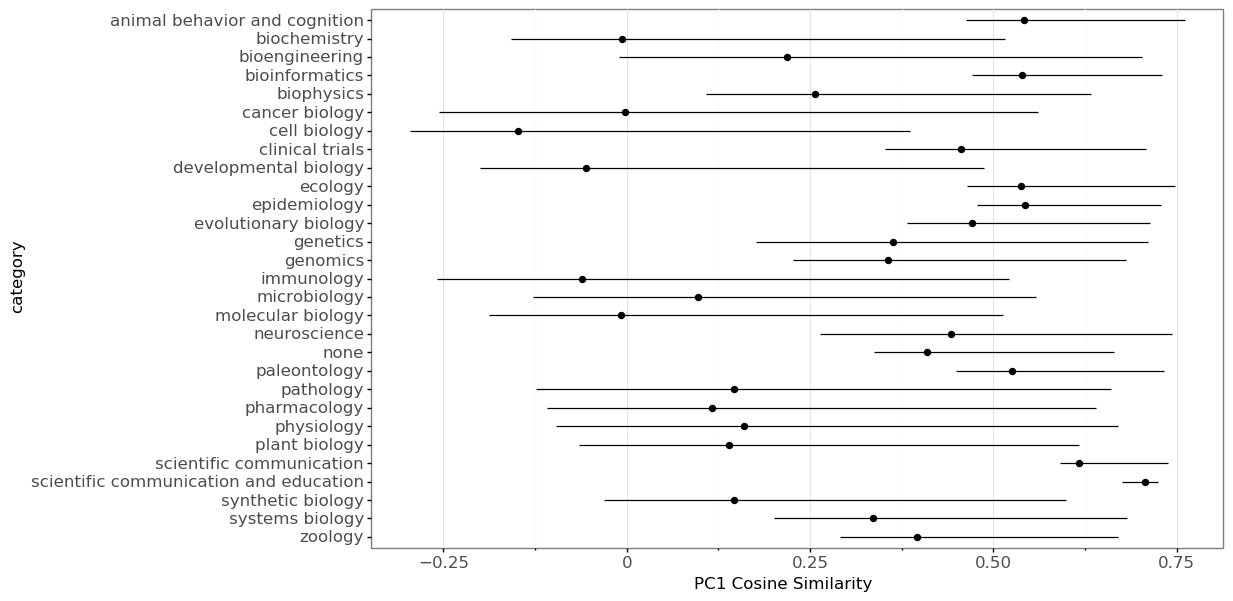

<ggplot: (8757266496744)>


In [11]:
g = (
    p9.ggplot(category_sim_df)
    + p9.aes(
        x="category", y="pca1_cossim",
        ymin="pca1_cossim_lower", ymax="pca1_cossim_upper"
    )
    + p9.geom_pointrange()
    + p9.coord_flip()
    + p9.theme_bw()
    + p9.scale_x_discrete(limits=category_sim_df.category.tolist()[::-1])
    + p9.theme(
        figure_size=(11, 7),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank()
    )
    + p9.labs(
        y = "PC1 Cosine Similarity"
    )
)
g.save("output/pca_plots/figures/category_pca1_95_ci.svg", dpi=500)
g.save("output/pca_plots/figures/category_pca1_95_ci.png", dpi=500)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca2_95_ci.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca2_95_ci.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


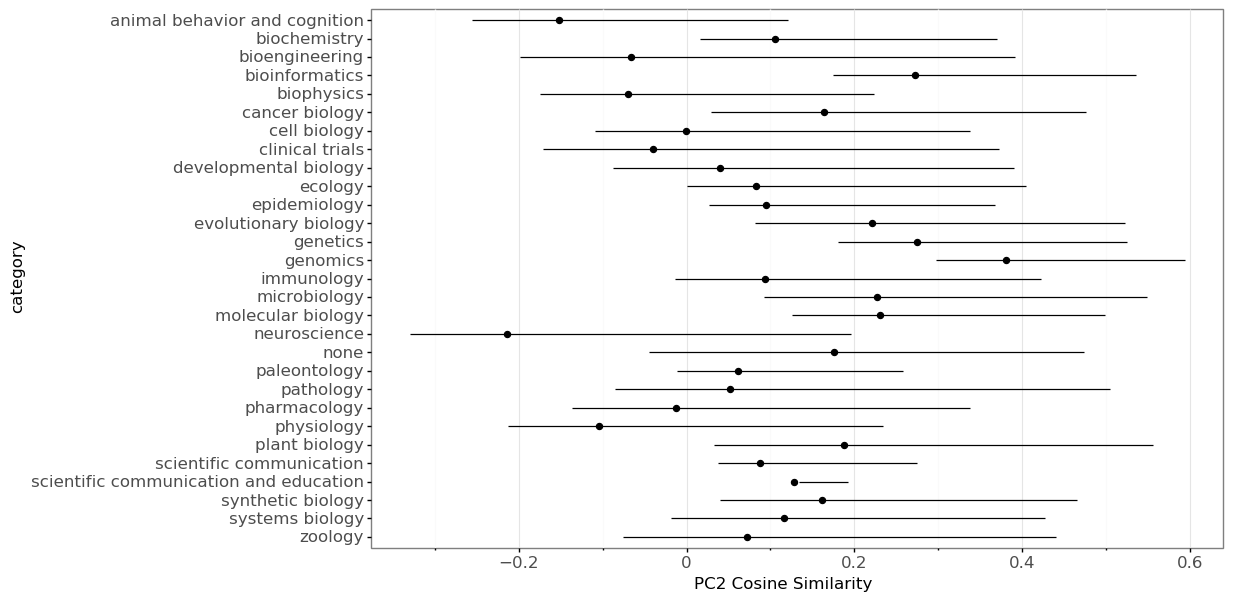

<ggplot: (8757218384637)>


In [12]:
g = (
    p9.ggplot(category_sim_df)
    + p9.aes(
        x="category", y="pca2_cossim", 
        ymax="pca2_cossim_upper", ymin="pca2_cossim_lower"
    )
    + p9.geom_pointrange()
    + p9.coord_flip()
    + p9.theme_bw()
    + p9.scale_x_discrete(limits=category_sim_df.category.tolist()[::-1])
    + p9.theme(
        figure_size=(11, 7),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank()
    )
    + p9.labs(
        y = "PC2 Cosine Similarity"
    )
)
g.save("output/pca_plots/figures/category_pca2_95_ci.svg", dpi=500)
g.save("output/pca_plots/figures/category_pca2_95_ci.png", dpi=500)
print(g)

# Plot Documents Projected on PCs Grouped by Category

In [13]:
projected_documents = reducer.transform(
    document_categories_df[[f"feat_{idx}" for idx in range(300)]]
)
projected_documents.shape

(71073, 50)

In [14]:
projected_documents_df = (
    pd.DataFrame(
        projected_documents,
        columns=[f"PC_{dim+1}" for dim in range(n_components)]
    )
    .assign(
        category = document_categories_df.category.tolist(),
        document = document_categories_df.document.tolist()
    )
)
projected_documents_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,document
0,3.194305,1.134085,1.084064,-0.143583,1.043321,-1.343665,0.579224,0.258148,0.045203,0.423111,...,0.067618,-0.257656,0.039235,0.225352,0.076584,0.051295,-0.079406,-0.236438,genetics,000026_v1.xml
1,2.949110,1.396484,0.295424,0.065541,0.186092,2.112833,0.490545,0.183757,0.641989,0.637272,...,0.087541,-0.057008,-0.188975,0.083384,0.114613,0.107043,-0.242111,0.033813,genomics,000042_v1.xml
2,0.303511,2.597960,-0.106586,0.371266,-0.652976,-1.834294,-0.310875,-0.122282,0.424456,-0.202739,...,-0.144753,-0.001959,-0.148692,0.057625,-0.177914,-0.186005,-0.013462,-0.101730,genomics,000067_v1.xml
3,1.405755,-1.976945,-1.310702,0.216065,1.571530,-0.161229,1.665388,-0.559321,0.557499,-0.804018,...,-0.156344,-0.080487,-0.081225,0.182263,-0.340147,0.087536,0.164891,0.001809,synthetic biology,000091_v1.xml
4,1.795873,1.542789,0.022271,-1.464324,0.565587,-1.918660,-0.797887,0.704201,0.285703,0.408147,...,-0.121957,0.036191,0.072662,-0.083365,0.274590,0.181480,-0.445493,-0.096457,evolutionary biology,000109_v1.xml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71068,-2.523089,1.253483,-0.527263,-0.140186,0.181830,-0.270601,-0.220712,0.016660,0.358549,0.115262,...,-0.254587,-0.008048,-0.000409,0.139486,-0.238315,-0.069321,-0.132876,0.095004,cell biology,872853_v1.xml
71069,-2.262986,0.458421,-2.554080,1.273399,2.029903,-0.389400,-1.113402,-1.774351,-0.414488,1.505322,...,0.136719,-0.092470,-0.242198,0.209596,-0.052946,0.534288,-0.164598,0.140255,biochemistry,872879_v1.xml
71070,-3.253319,-0.906144,-0.631545,0.450835,1.578467,-0.102734,0.272205,1.502941,0.549432,0.740617,...,-0.009180,-0.139636,0.363352,0.336548,-0.146758,0.145650,-0.050986,-0.084018,cell biology,872952_v1.xml
71071,-4.359351,-1.140533,1.336358,1.185831,-0.194498,-0.089951,0.349474,1.413349,-0.134340,0.417022,...,0.419364,0.215234,0.104079,0.180077,0.018683,-0.238216,-0.021266,-0.092954,developmental biology,873109_v1.xml


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 11 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_box_plot_pc1.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 11 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_box_plot_pc1.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)


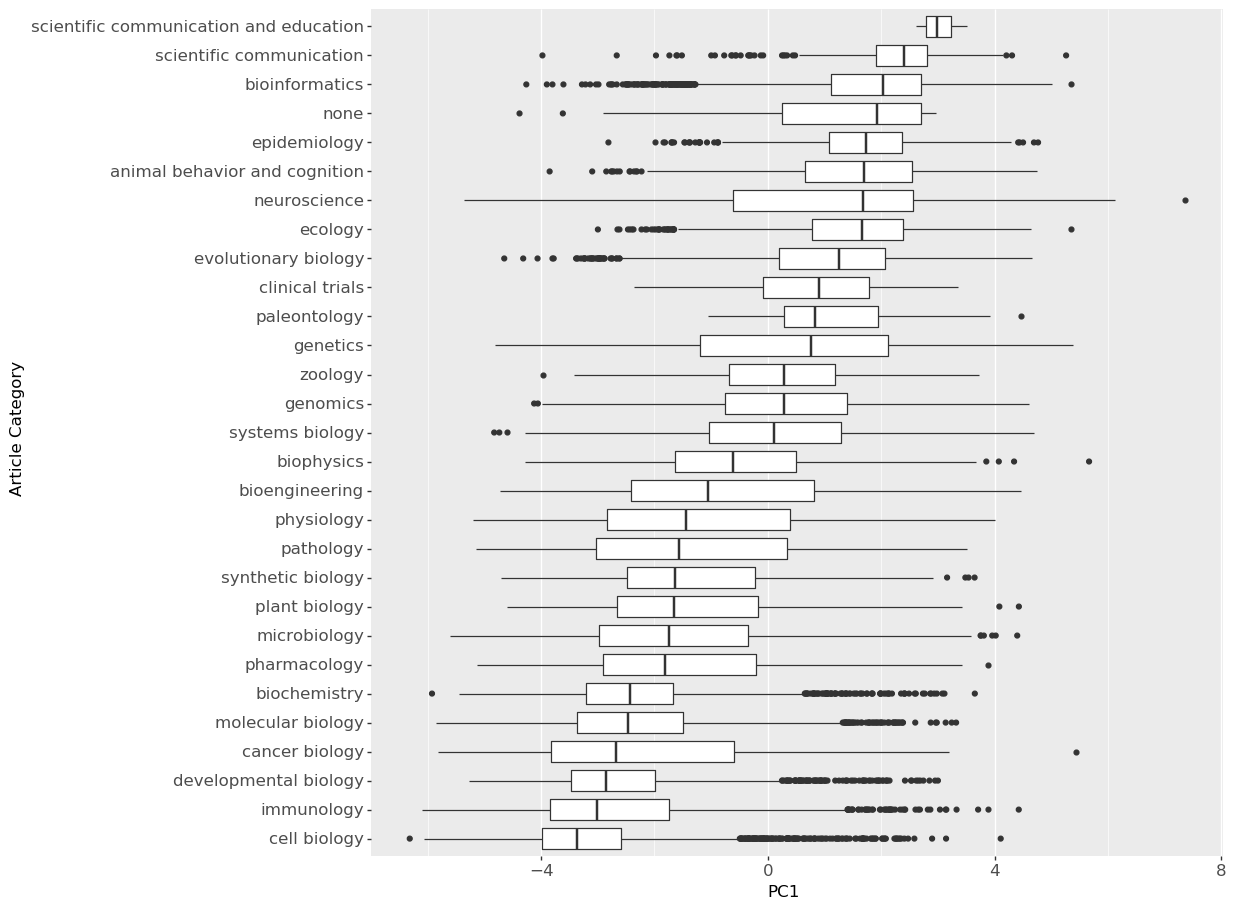

<ggplot: (-9223363279636673932)>


In [15]:
g = (
    p9.ggplot(projected_documents_df)
    + p9.aes(x="factor(category)", y="PC_1")
    + p9.geom_boxplot()
    + p9.coord_flip()
    + p9.theme(
        figure_size=(11, 11),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank()
    )
    + p9.scale_x_discrete(
        limits=(
            projected_documents_df
            .groupby("category")
            .agg({"PC_1":"median"})
            .sort_values("PC_1", ascending=False)
            .reset_index()
            .category
            .tolist()
            [::-1]
        )
    )
    + p9.labs(
        x = "Article Category",
        y = "PC1"
    )
)
g.save("output/pca_plots/figures/category_box_plot_pc1.png", dpi=500)
g.save("output/pca_plots/figures/category_box_plot_pc1.svg", dpi=500)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 11 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_box_plot_pc2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 11 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_box_plot_pc2.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)


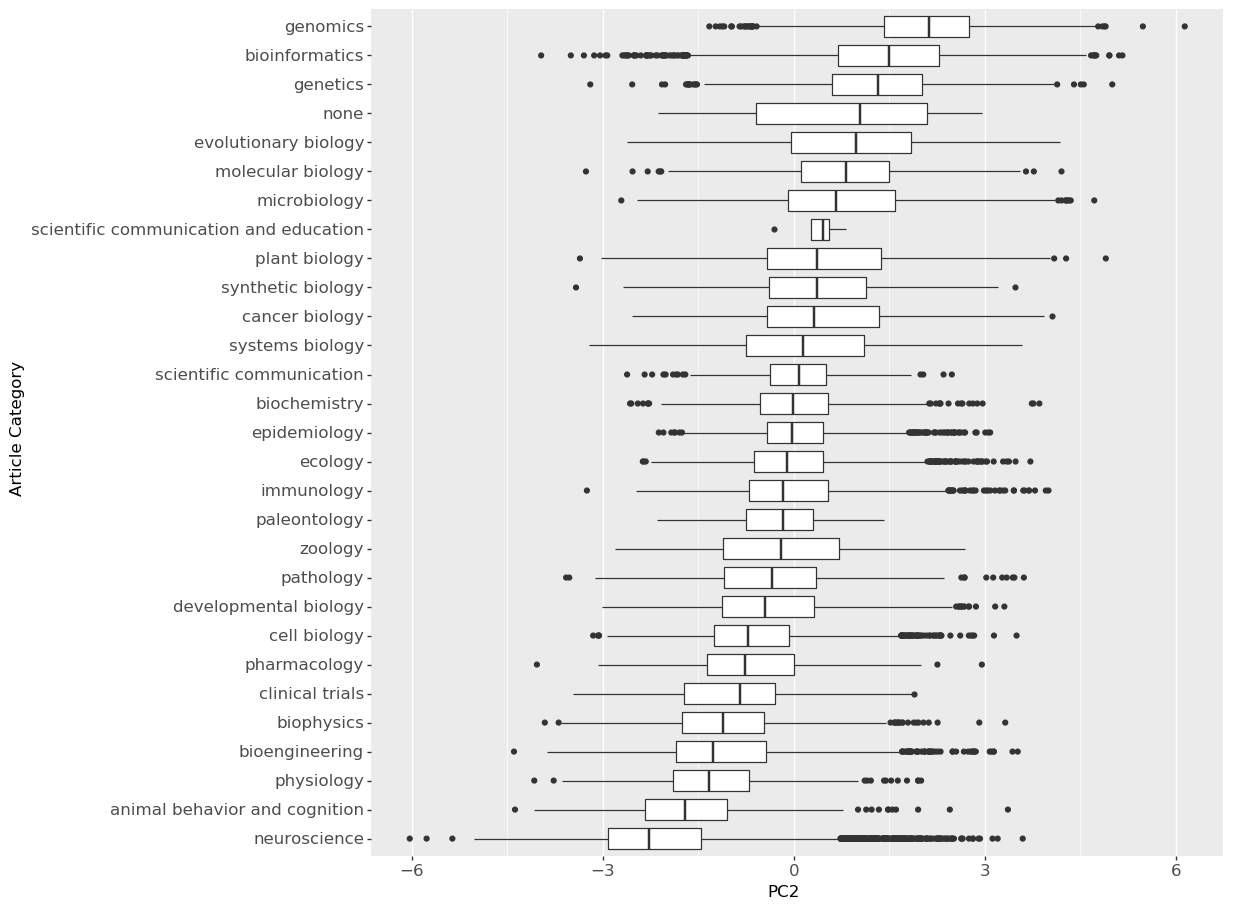

<ggplot: (8757219338921)>


In [16]:
g = (
    p9.ggplot(projected_documents_df)
    + p9.aes(x="factor(category)", y="PC_2")
    + p9.geom_boxplot()
    + p9.coord_flip()
    + p9.theme(
        figure_size=(11, 11),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank()
    )
    + p9.scale_x_discrete(
        limits=(
            projected_documents_df
            .groupby("category")
            .agg({"PC_2":"median"})
            .sort_values("PC_2", ascending=False)
            .reset_index()
            .category
            .tolist()
            [::-1]
        )
    )
    + p9.labs(
        x = "Article Category",
        y = "PC2"
    )
)
g.save("output/pca_plots/figures/category_box_plot_pc2.png", dpi=500)
g.save("output/pca_plots/figures/category_box_plot_pc2.svg", dpi=500)
print(g)

# Tables with Figures

In [17]:
def dump_figures_and_table(
    table_df, figure_selector, 
    output_path="output/table", 
    column_value="PC_1"
):
    
    # Output figures to folder
    for idx, row in table_df.iterrows():
        subprocess.Popen([
            "unzip", "-j",
            Path("..")/Path(row['hash']), 
            Path("content")/Path(figure_selector[row['document']]),
            "-d", Path("output/table_figures")
        ])
        
    # Output table in Manubot format
    # to make incorporating this figure much easier in text
    # http://greenelab.github.io/annorxiver_manuscript
    (
        table_df
        [["document", "doi", column_value]]
        # doi - a manubot formatted doi link. Manubot creaes citations via [@doi:doi_link]
        # figure - a markdown formmated link to show figure images within a given table.
        .assign(
            doi=lambda x: x.doi.apply(lambda link: f"[@doi:{link}]"),
            figure=lambda x: x.document.apply(lambda doc: f"![](table_figures/{document_figure_selector[doc]})")
        )
        .drop("document", axis=1)
        .to_csv(f"{output_path}.tsv", sep="\t", index=False)
    )

In [18]:
document_hash_df = pd.read_csv(
    "../biorxiv_doc_hash_mapper.tsv", sep="\t"
)
document_hash_df.head()

,hash,doc_number
0,Back_Content/Batch_37/9053e435-6c1c-1014-ae3b-...,344929_v1.xml
1,Back_Content/Batch_37/7b48c4a4-6c82-1014-86f6-...,337824_v1.xml
2,Back_Content/Batch_37/9022c674-6c41-1014-9caf-...,343640_v1.xml
3,Back_Content/Batch_37/e555f7da-6c1c-1014-8142-...,346395_v1.xml
4,Back_Content/Batch_37/bedf3bbe-6bfd-1014-b91a-...,342253_v1.xml


## Top PC1

In [19]:
top_pc1_documents = (
    journal_map_df
    [["document", "doi"]]
    .merge(
        projected_documents_df
        .query("category=='systems biology'")
        .sort_values("PC_1", ascending=False)
        .head(),
        on='document'
    )
    .merge(document_hash_df, left_on="document", right_on="doc_number")
)
top_pc1_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,044818_v1.xml,10.1101/044818,4.355296,0.701121,-0.917196,1.934185,0.840629,2.159144,1.597697,-0.159799,...,0.207891,0.009730,-0.196102,-0.005145,-0.142195,0.113150,0.150636,systems biology,Back_Content/Batch_05/f9f93e4a-6c04-1014-a553-...,044818_v1.xml
1,107250_v1.xml,10.1101/107250,4.321848,0.517221,-2.233436,0.756426,-0.588429,1.643951,1.363151,0.201107,...,0.131026,0.187173,-0.049735,-0.101073,-0.000026,0.023265,0.285973,systems biology,Back_Content/Batch_13/cd2e8e00-6c08-1014-ac3f-...,107250_v1.xml
2,197400_v1.xml,10.1101/197400,4.700555,-0.202220,-2.067039,0.544843,0.122205,0.704985,2.330092,0.266028,...,-0.011088,-0.183077,-0.151169,-0.065518,-0.045915,0.045492,0.332093,systems biology,Back_Content/Batch_22/5ccdf4fe-6c04-1014-9393-...,197400_v1.xml
3,769299_v1.xml,10.1101/769299,4.351518,-0.253519,-2.209727,0.352058,0.315393,0.080542,2.245532,0.144070,...,-0.090200,-0.049515,-0.193918,0.031493,0.054039,0.058935,0.424861,systems biology,Current_Content/September_2019/Batch_#290/e1bb...,769299_v1.xml
4,825943_v1.xml,10.1101/825943,4.410661,0.816269,-0.759627,2.738379,2.200390,3.554049,3.372015,0.655272,...,0.250405,-0.086011,-0.195883,-0.070873,0.067652,0.012047,0.423544,systems biology,Current_Content/November_2019/4fffd421-6c0e-10...,825943_v1.xml


In [20]:
document_figure_selector = {
    "044818_v1.xml": "044818_fig1.tif",
    "107250_v1.xml": "107250_fig1.tif",
    "197400_v1.xml": "197400_fig1.tif",
    "769299_v1.xml": "769299v1_fig1.tif",
    "825943_v1.xml": "825943v1_fig1.tif"
}

In [21]:
dump_figures_and_table(
    top_pc1_documents, 
    document_figure_selector,
    output_path="output/tables/top_pc1_table",
    column_value="PC_1"
)

## Bottom PC1

In [22]:
bottom_pc1_documents = (
    journal_map_df
    [["document", "doi"]]
    .merge(
        projected_documents_df
        .query("category=='systems biology'")
        .sort_values("PC_1", ascending=True)
        .head(),
        on='document'
    )
    .merge(
        document_hash_df, 
        left_on="document", 
        right_on="doc_number"
    )
)
bottom_pc1_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,371922_v1.xml,10.1101/371922,-4.279017,-0.718003,0.394572,0.051230,-1.433396,-0.483059,1.332681,0.282955,...,0.042411,-0.233003,-0.241737,0.177474,0.207998,0.093323,-0.074783,systems biology,Back_Content/Batch_40/5440df02-6c12-1014-8157-...,371922_v1.xml
1,455048_v1.xml,10.1101/455048,-4.263964,-0.202224,0.377484,0.608195,0.744021,-0.008612,1.024681,-0.118550,...,-0.239542,0.251326,-0.189194,-0.081879,-0.027811,-0.171624,0.020126,systems biology,Back_Content/Batch_50/94c86cc3-6bfa-1014-a920-...,455048_v1.xml
2,733162_v1.xml,10.1101/733162,-4.592210,-1.032307,0.719670,-0.269660,-0.561016,-0.186927,1.911958,-0.482185,...,0.257076,-0.033188,-0.399332,0.151183,0.080653,-0.047709,-0.073754,systems biology,Current_Content/August_2019/Batch_#254/3cb22cf...,733162_v1.xml
3,745943_v1.xml,10.1101/745943,-4.736614,-1.201096,1.669934,-0.450040,-1.839753,0.411696,1.208251,-0.459800,...,0.121746,-0.279230,0.195148,0.202476,-0.056394,-0.178162,-0.034775,systems biology,Current_Content/August_2019/Batch_#269/62b5959...,745943_v1.xml
4,754572_v1.xml,10.1101/754572,-4.826794,-0.338750,0.308145,-0.055323,-0.674592,-0.468552,1.618293,0.254840,...,0.248031,-0.087520,-0.274605,0.022040,0.212409,0.146506,0.024170,systems biology,Current_Content/September_2019/Batch_#273/8f50...,754572_v1.xml


In [23]:
document_figure_selector = {
    "371922_v1.xml": "371922_fig1.tif",
    "455048_v1.xml": "455048_fig1.tif",
    "733162_v1.xml": "733162v1_fig1.tif",
    "745943_v1.xml": "745943v1_fig1.tif",
    "754572_v1.xml": "754572v1_fig1.tif"
}

In [24]:
dump_figures_and_table(
    bottom_pc1_documents, 
    document_figure_selector,
    output_path="output/tables/bottom_pc1_table",
    column_value="PC_1"
)

## Top PC2

In [25]:
top_pc2_documents = (
    journal_map_df
    [["document", "doi"]]
    .merge(
        projected_documents_df
        .query("category=='systems biology'")
        .sort_values("PC_2", ascending=False)
        .head(),
        on='document'
    )
    .merge(
        document_hash_df, 
        left_on="document", 
        right_on="doc_number"
    )
)
top_pc2_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,220152_v1.xml,10.1101/220152,1.304514,3.363258,-0.481922,1.921135,-0.426739,1.524387,-0.288433,0.276127,...,-0.002429,-0.090698,0.032552,0.253369,0.015472,-0.134565,0.073603,systems biology,Back_Content/Batch_25/4b52b43b-6c14-1014-ade0-...,220152_v1.xml
1,328591_v1.xml,10.1101/328591,0.910363,3.287428,-0.018461,1.710891,0.344823,0.981251,-0.104874,-0.274013,...,-0.072855,-0.230996,-0.147783,-0.190137,0.153113,-0.130038,-0.032592,systems biology,Back_Content/Batch_36/49399edf-6c41-1014-9d7a-...,328591_v1.xml
2,392779_v1.xml,10.1101/392779,1.560786,3.381491,1.612145,2.189737,0.392616,-0.066910,0.000566,0.162701,...,0.334681,-0.173397,0.245352,-0.193340,0.195765,0.037979,0.219902,systems biology,Back_Content/Batch_42/12cf6b90-6c29-1014-9350-...,392779_v1.xml
3,484204_v2.xml,10.1101/484204,2.720501,3.470388,0.833171,1.286508,0.365512,-0.024936,0.156049,-0.245944,...,-0.031234,-0.170161,0.007301,-0.021741,0.082896,0.135603,-0.074158,systems biology,Current_Content/April_2019/Batch_#148/247eb1e4...,484204_v2.xml
4,781328_v1.xml,10.1101/781328,0.331002,3.586570,-0.317184,0.241341,0.359752,-0.255881,-0.988478,-0.243884,...,0.151671,0.037668,0.042524,-0.142538,-0.135454,0.084389,0.137661,systems biology,Current_Content/September_2019/Batch_#297/849a...,781328_v1.xml


In [26]:
document_figure_selector = {
    "220152_v1.xml": "220152_fig3.tif",
    "328591_v1.xml": "328591_fig1.tif",
    "392779_v1.xml": "392779_fig1.tif",
    "484204_v2.xml": "484204v2_fig1.tif",
    "781328_v1.xml": "781328v1_fig3.tif"
}

In [27]:
dump_figures_and_table(
    top_pc2_documents, 
    document_figure_selector,
    output_path="output/tables/top_pc2_table",
    column_value="PC_2"
)

## Bottom PC2

In [28]:
bottom_pc2_documents = (
    journal_map_df
    [["document", "doi"]]
    .merge(
        projected_documents_df
        .query("category=='systems biology'")
        .sort_values("PC_2", ascending=True)
        .head(),
        on='document'
    )
    .merge(document_hash_df, left_on="document", right_on="doc_number")
)
bottom_pc2_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,019687_v1.xml,10.1101/019687,0.982648,-2.704710,-1.263196,-0.811585,0.779109,-2.575803,1.355145,-0.673983,...,-0.106270,0.039907,0.214970,-0.179898,-0.045264,-0.000098,0.112136,systems biology,Back_Content/Batch_04/06bb31a8-6c43-1014-a1fe-...,019687_v1.xml
1,301051_v1.xml,10.1101/301051,-0.400585,-3.047342,0.604323,1.140236,0.241031,-1.584906,0.032672,-0.315671,...,0.128152,0.064446,0.133910,-0.057440,0.127916,0.184885,0.054859,systems biology,Back_Content/Batch_33/df443335-6c02-1014-94cf-...,301051_v1.xml
2,357939_v1.xml,10.1101/357939,-0.525785,-2.775745,-1.648306,0.162995,0.395138,-1.108064,0.604212,0.212358,...,0.234773,0.181496,0.036643,0.024034,-0.072032,0.074418,-0.210270,systems biology,Back_Content/Batch_39/2775d2e5-6bfe-1014-9084-...,357939_v1.xml
3,386367_v3.xml,10.1101/386367,-0.432874,-3.215335,-1.183551,0.701786,1.492874,-0.007403,0.699176,0.279193,...,-0.012452,0.167300,-0.262696,0.059908,-0.545060,0.107802,-0.102994,systems biology,Current_Content/May_2019/Batch_#178/e7f08d26-6...,386367_v3.xml
4,840280_v1.xml,10.1101/840280,-1.028726,-3.107716,-1.088356,-0.672840,0.258882,-0.339931,0.362887,0.072032,...,0.031944,0.322415,-0.224519,0.123189,0.094486,0.069796,-0.273719,systems biology,Current_Content/November_2019/c7a0dac3-6c0a-10...,840280_v1.xml


In [29]:
document_figure_selector = {
    "019687_v1.xml": "019687_fig1.tif",
    "301051_v1.xml": "301051_fig3.tif",
    "357939_v1.xml": "357939_fig4.tif",
    "386367_v3.xml": "386367v3_fig1.tif",
    "840280_v1.xml": "840280v1_fig1.tif"
}

In [30]:
dump_figures_and_table(
    bottom_pc2_documents, 
    document_figure_selector,
    output_path="output/tables/bottom_pc2_table",
    column_value="PC_2"
)